<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/34_4_Multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание 1. На 3 балла:**

1. Ваша задача используя модель и датасет из третей части урока, самостоятельно познакомиться с библиотекой [Albumentations](https://albumentations.ai/) и применить несколько методов аугментации для семантической сегментации снимков с беспилотника.

2. Используйте коллбэк функцию для предварительной остановки процесса обучения. Подумайте: какие параметры для остановки вы применили и почему?

**Задание 2. На 4 балла:**

1. Ваша задача зарегистрироваться на платформе по проведению соревнований в сфере машинного обучения [kaggle](https://www.kaggle.com/).
2. Загрузить датасет с данными о радиографическом ислледовании по COVID-19:

3. Обучить U-net подобную архитектуру сегментировать легкие человека на радиографическом снимке. Используйте данные о нормальном состоянии легких в папке `covid19-radiography-database/COVID-19_Radiography_Dataset/Normal`.

4. Отобразите по 10 снимков с оригинальным изображением, оригинальной маской и предсказанной маской.

In [1]:
%%capture
!pip install opendatasets

In [2]:
import warnings
warnings.filterwarnings("ignore")

import random
import os
import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd
import tensorflow as tf                                                               # библиотека Tensorflow
import keras

from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras
from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса
                                                                  # библиотека обработки табличных данных
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)
import opendatasets as op
import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

In [3]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maxxxvs
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:35<00:00, 22.7MB/s]


In [4]:
dataset_path = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal"
image_dir = "images"
label_dir = "masks"

In [5]:
directory_images = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
directory_mask = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'

files = os.listdir(directory_images)
print(f"Всего изображений в папке: {len(files)} шт.")

files = os.listdir(directory_mask)
print(f"Всего масок в папке: {len(files)} шт.")

Всего изображений в папке: 10192 шт.
Всего масок в папке: 10192 шт.


In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
      plt.axis('off')
  plt.show()

In [7]:
random_number = random.randint(0, len(files))

Номер изображенной пары images/masks: 10133


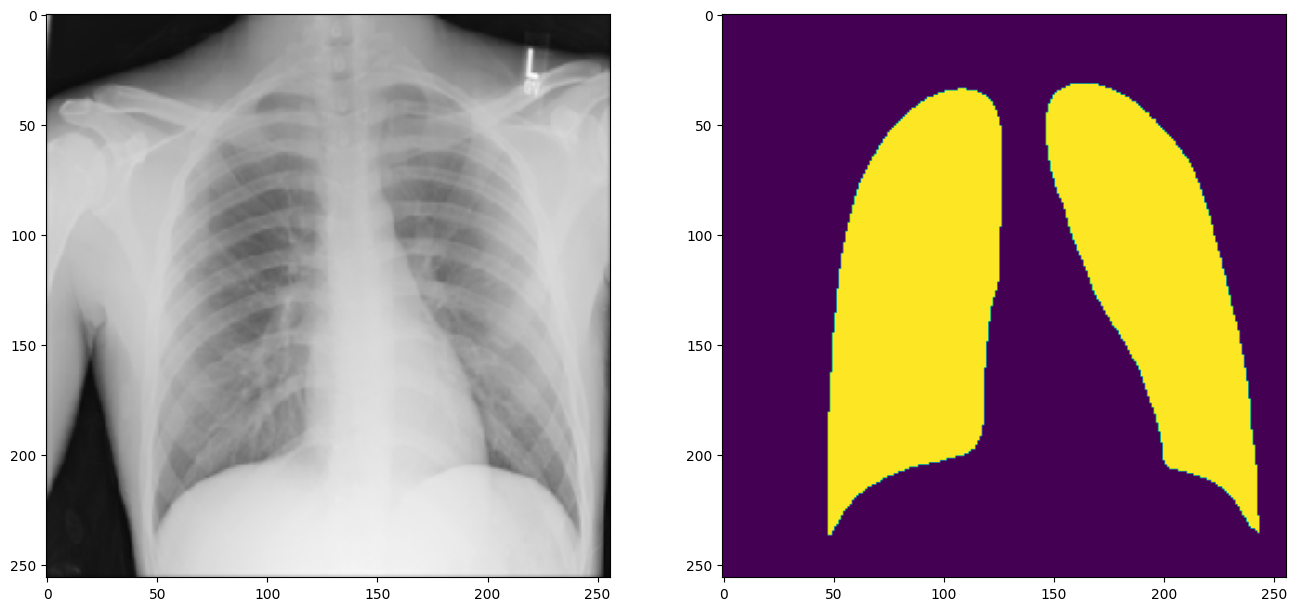

In [8]:
original_image = os.path.join(dataset_path, image_dir, files[random_number])       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, files[random_number]) # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

print(f"Номер изображенной пары images/masks: {random_number}")

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [9]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")])

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")])

batch_size = 16
img_size = (256, 256)
num_classes = 2

In [73]:
# Генератор для перебора данных (в виде массивов Numpy)

class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = num_classes, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255 # нормализуем изображение
            y[_] = to_categorical(mask / 255, num_classes=num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y


In [74]:
seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [75]:
# val_samples = 1192

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:9000]
train_target_img_path = target_img_path[:9000]
val_input_img_path = input_img_path[9001:]
val_target_img_path = target_img_path[9001:]

In [76]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, num_classes)
val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, num_classes, validation = True)

In [77]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)

    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

In [78]:
# Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

In [79]:
# Наша интерпретация модели U-net
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышка задаем 2-мя синими блоками
    conv_block = convolution_operation(encoder_4, 64*16)

    # Задаем блоки декодировщика и передаем ему латеральные соединения от кодировщиков
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (1, 1), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [80]:
# num_classes = 2 # 2 класса объектов
input_shape = (256, 256, 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, num_classes) # инициализируем модель

In [81]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)]

In [82]:
model.summary() # отчет о структуре модели

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 256, 256, 64)   │            256 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_90 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ re_lu_90[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 256, 256, 64)   │            256 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_91 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 128, 128, 64)   │              0 │ re_lu_91[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 128, 128, 128)  │            512 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_92 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ re_lu_92[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_93    │ (None, 128, 128, 128)  │            512 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_93 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 64, 64, 128)    │              0 │ re_lu_93[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_21[0][0] │
├──────────────────────

 Total params: 31,055,362 (118.47 MB)

 Trainable params: 31,043,586 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

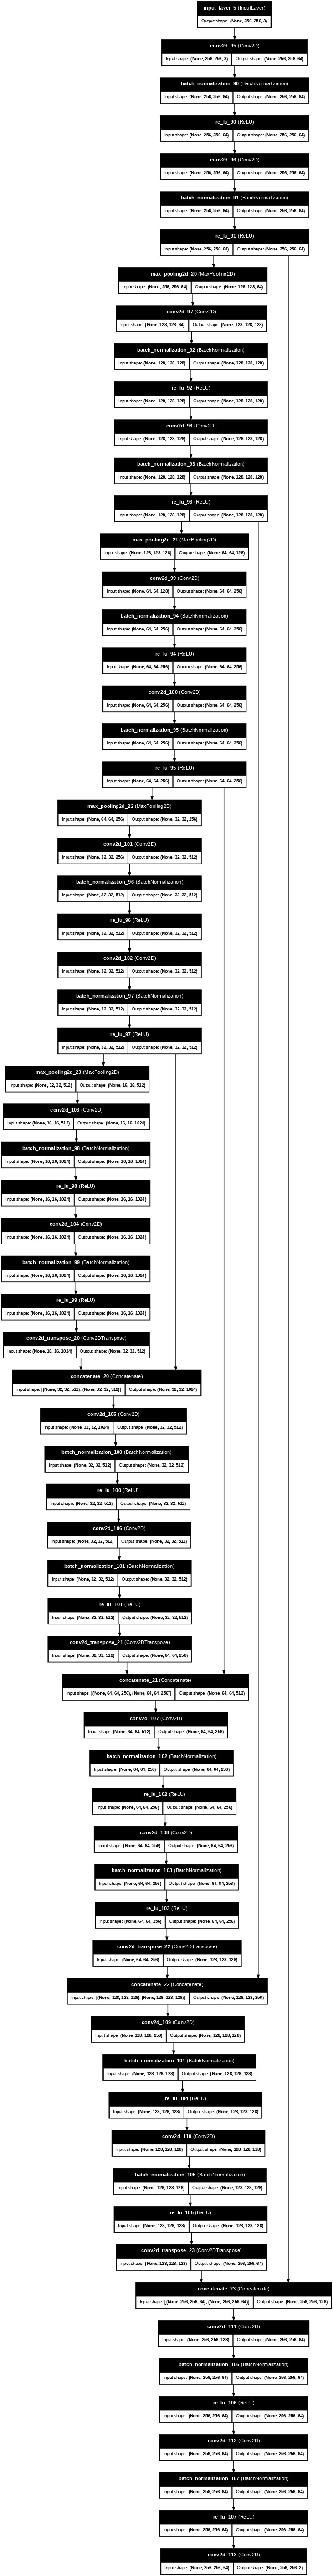

In [83]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=50)

In [84]:
epochs = 5
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 572s 865ms/step - accuracy: 0.9315 - loss: 0.1663 - val_accuracy: 0.9701 - val_loss: 0.0839
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 470s 831ms/step - accuracy: 0.9892 - loss: 0.0280 - val_accuracy: 0.9932 - val_loss: 0.0172
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 465s 826ms/step - accuracy: 0.9920 - loss: 0.0202 - val_accuracy: 0.9139 - val_loss: 0.5350
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 502s 827ms/step - accuracy: 0.9924 - loss: 0.0194 - val_accuracy: 0.9841 - val_loss: 0.0470
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 504s 830ms/step - accuracy: 0.9932 - loss: 0.0173 - val_accuracy: 0.9938 - val_loss: 0.0154


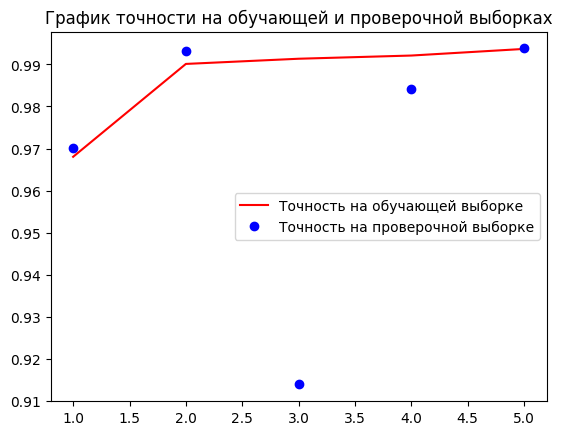

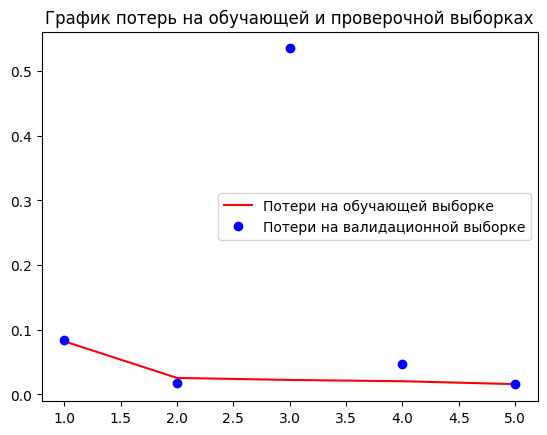

In [85]:
acc = history.history['accuracy']                                          # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                                  # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          # строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   # строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           # заголовок графика
plt.legend()                                                               # легенда графика
plt.figure()                                                               # создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           # строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  # строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             # заголовок графика
plt.legend()                                                               # легенда графика
plt.show()

In [86]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


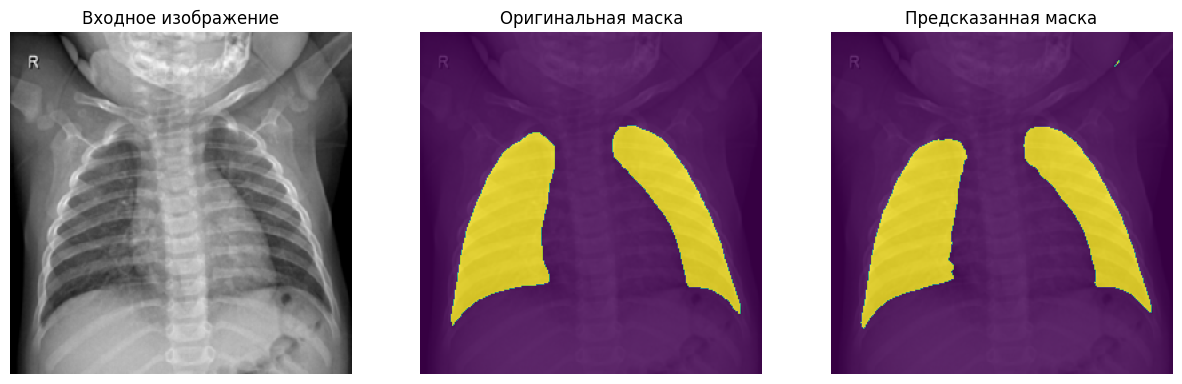

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


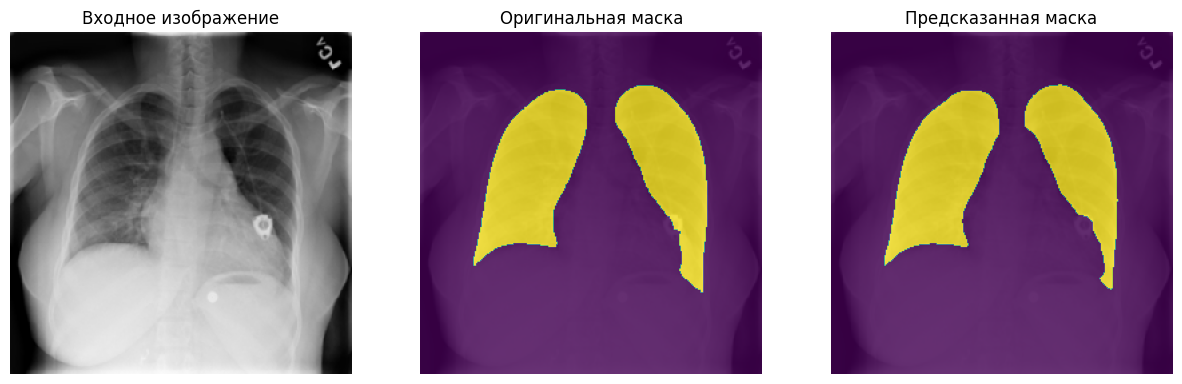

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


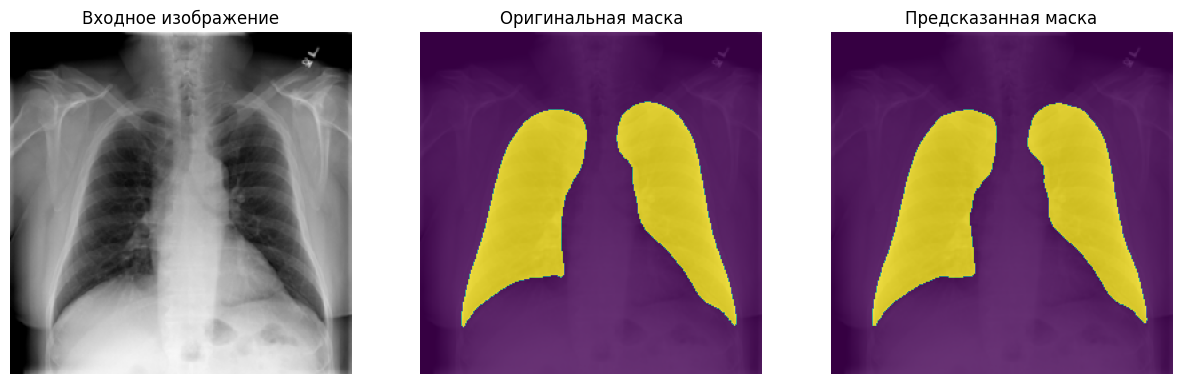

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


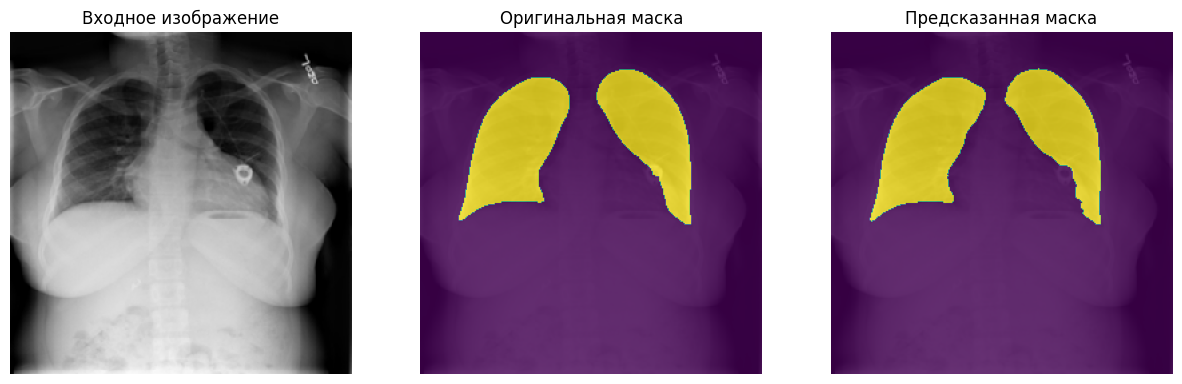

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


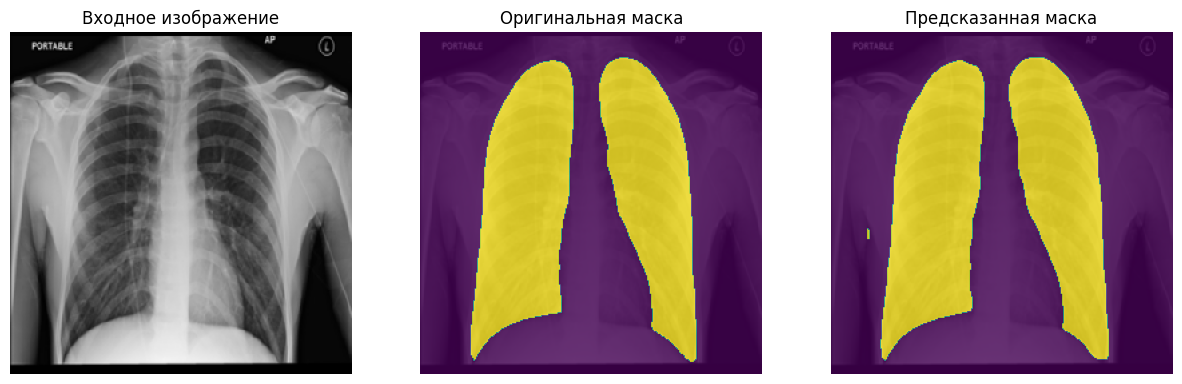

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


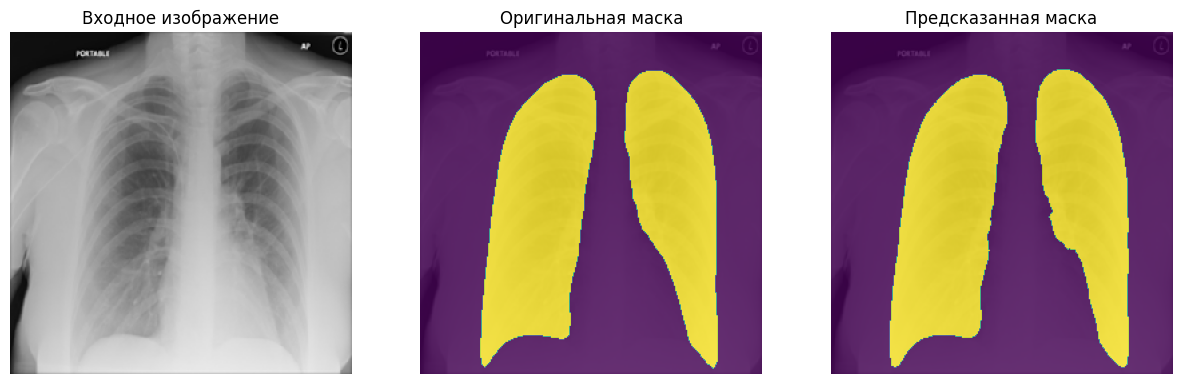

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


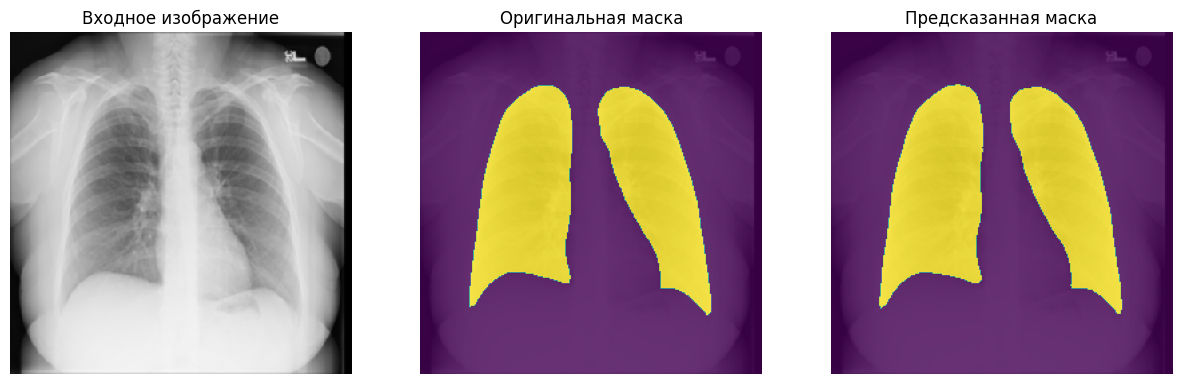

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


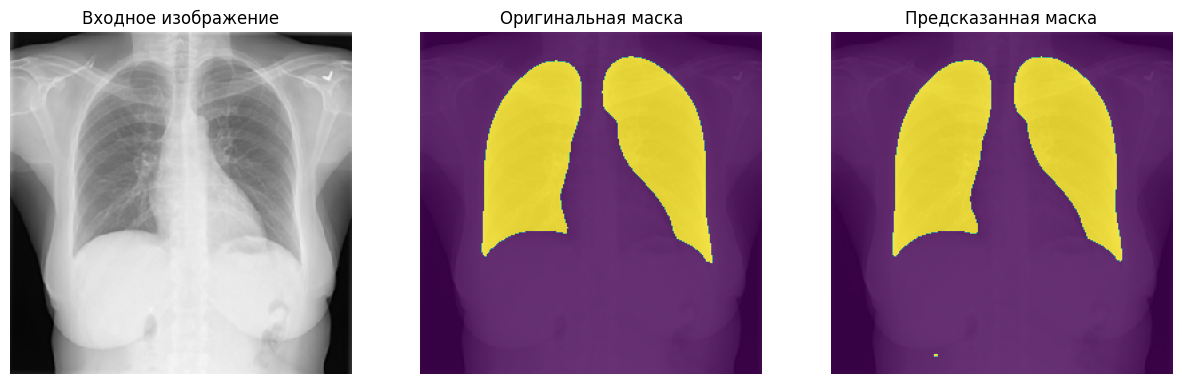

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


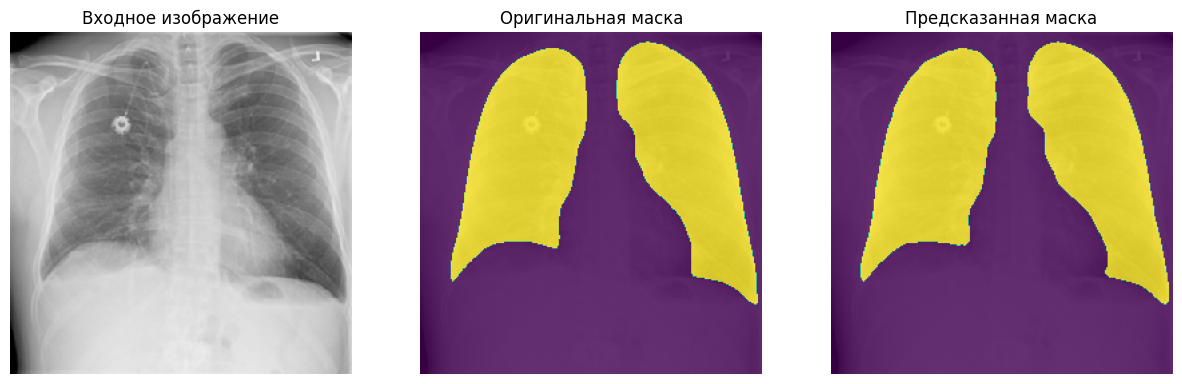

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


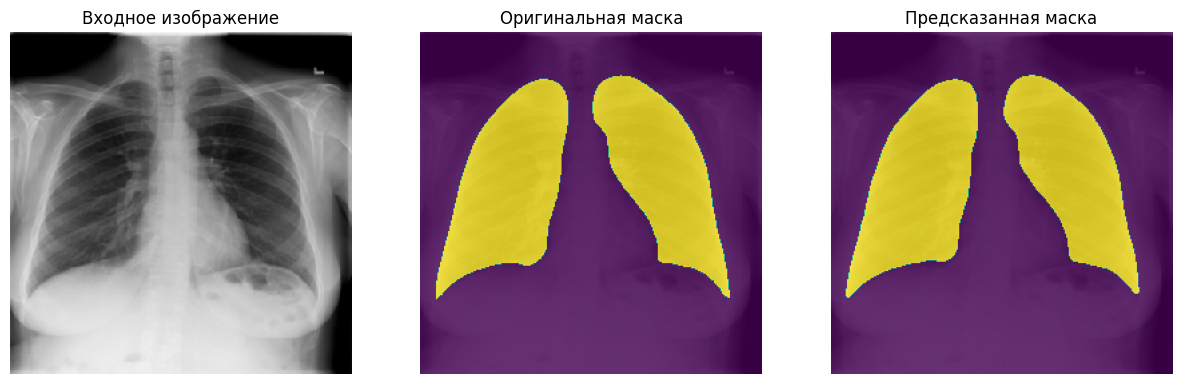

In [87]:
for index in range(10):
    img = np.array(load_img(val_input_img_path[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную

In [88]:
test_2 = model.evaluate(train_gen)
print(test_2)

562/562 ━━━━━━━━━━━━━━━━━━━━ 166s 296ms/step - accuracy: 0.9933 - loss: 0.0170
[0.016957499086856842, 0.9932874441146851]
